In [1]:
# PYTHON IMPORTS
import os, copy, traceback
from tqdm.notebook import trange, tqdm
import glob

# IMAGE IMPORTS 
from PIL import Image
import cv2

# DATA IMPORTS 
import numpy as np

# PLOTTING
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# NEURAL NETWORK
import torch, kornia
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets
from torchvision.transforms import ToPILImage, GaussianBlur
from torchvision.transforms import Compose, RandomCrop, ToTensor, Normalize
import torch.optim.lr_scheduler as lr_scheduler
import torchvision.models as models
# from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# MY OWN CLASSES
from TPNN import *
from PlottingUtils import *
from DataUtils import * 

Image.MAX_IMAGE_PIXELS = 933120000

In [7]:
class NN_Dataset_V3(Dataset):
    def __init__(self, image_dir, mask_dir, input_transform=None, transform=None, resize=None):
        """
        Args:
            image_dir (str): Directory with all the images.
            mask_dir (str): Directory with all the masks.
            transform (callable, optional): Transformation to apply to both images and masks.
        """
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_names = sorted(os.listdir(image_dir))  # Ensure matching order
        self.mask_names = sorted(os.listdir(mask_dir))   # Ensure matching order
        self.transform = transform
        self.input_transform = input_transform

        # Preload all images and masks into memory
        self.images = []
        self.masks = []
        for fn in self.image_names:
            image = Image.open(os.path.join(image_dir, fn)).convert('L')
            if resize is not None:
                image = cv2.resize(np.array(image).astype(np.uint8), (resize, resize), interpolation= cv2.INTER_AREA)            
            image = Image.fromarray(np.array(image).astype(np.uint8))
            self.images.append(image)
                
        self.targets = loadClasses(mask_dir, fns=self.image_names, flip=False)

        if resize is not None:
            self.targets = [Image.fromarray(cv2.resize(np.array(im), (resize, resize), interpolation= cv2.INTER_AREA)) for im in self.targets]
        
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Return preloaded image and mask
        image = self.images[idx]
        target_image = self.targets[idx]

        seed = np.random.randint(2147483647)            
        if self.transform is not None:
            random.seed(seed)
            torch.manual_seed(seed)
            image = self.transform(image)            
            random.seed(seed)
            torch.manual_seed(seed)
            target_image = self.transform(target_image)
        
        if self.input_transform is not None:
            image = self.input_transform(image)

        if torch.max(target_image) < 1:
            target_image = target_image * 255

        return image, target_image, self.image_names[idx]


# In[3]:


base_dir = r"C:\Users\fhacesga\OneDrive - University Of Houston\AAA_RECTDNN\data\FLNN\AAA_NewDataset_2\\"

input_folder        = f"{base_dir}/in"
val_folder          = f"{base_dir}/val"
train_target_folder = f"{base_dir}/out"
val_target_folder   = f"{base_dir}/val_out"
batch_size          = 2
verbose_level       = 2

tensor = transforms.Compose([
    transforms.ToTensor(),
])

transform = transforms.Compose([
    transforms.RandomRotation(degrees=45),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
])



class LocalizedPixelTransform(torch.nn.Module):  # Subclass torch.nn.Module
    def __init__(self, blur_prob=0.5, noise_prob=0.5, illumination_prob=0.5, mask_scale=0.5):
        super().__init__()
        self.blur_prob = blur_prob
        self.noise_prob = noise_prob
        self.illumination_prob = illumination_prob
        self.mask_scale = mask_scale  # Scale controls how much of the image is affected

    def generate_mask(self, img_shape):
        # Generate a random gradient mask (1 for transformation, 0 elsewhere)
        mask = torch.zeros(img_shape[-2:], dtype=torch.float32)
        h, w = mask.shape
        # Apply a random rectangle in the image as a "local region"
        x1, y1 = int(w * torch.rand(1).item() * self.mask_scale), int(h * torch.rand(1).item() * self.mask_scale)
        x2, y2 = min(w, x1 + int(w * self.mask_scale)), min(h, y1 + int(h * self.mask_scale))
        mask[y1:y2, x1:x2] = 1.0
        return mask

    def forward(self, img):
        # Ensure img is a tensor in [C, H, W] format
        if not isinstance(img, torch.Tensor):
            raise TypeError("Input must be a PyTorch tensor.")

        img_shape = img.shape[-2:]  # H, W
        mask = self.generate_mask(img_shape).to(img.device)  # Localized mask

        # Apply blur
        if torch.rand(1).item() < self.blur_prob:
            blurred = kornia.filters.gaussian_blur2d(img.unsqueeze(0), (5, 5), (1.5, 1.5)).squeeze(0)
            img = img * (1 - mask) + blurred * mask

        # Add random noise
        if torch.rand(1).item() < self.noise_prob:
            noise = torch.randn_like(img) * 0.05
            img = img * (1 - mask) + (img + noise) * mask
            img = torch.clamp(img, 0, 1)

        # Adjust illumination
        if torch.rand(1).item() < self.illumination_prob:
            factor = 1.0 + (torch.rand(1).item() - 0.5) * 0.4
            illuminated = torch.clamp(img * factor, 0, 1)
            img = img * (1 - mask) + illuminated * mask

        return img

In [8]:
# Integrate into the transform pipeline
input_transform = transforms.RandomApply(torch.nn.ModuleList([
    transforms.ColorJitter(0.3, 0.3, 0.3, 0.3),
    # LocalizedPixelTransform(blur_prob=0.7, noise_prob=0.5, illumination_prob=0.6, mask_scale=0.3),
]), p=1)

tensor = transforms.Compose([transforms.ToTensor()])

train_dataset = NN_Dataset_V3(input_folder, train_target_folder, transform=transform, 
                              input_transform=input_transform, resize=1536)
train_loader  = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_dataset = NN_Dataset_V3(val_folder, val_target_folder, transform=transform, 
                              input_transform=input_transform, resize=1536)
val_loader  = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

['ZoneA']
{'4802960160B', '480296A_52', '4802960080E', '4802960090C', '4802960155D', '4802960155B', '4855140009C', '4802960155E', '481141_2', '480296A_66', '4802960155C', '4802960125B', '4802960080D', '4802960095C', '48201C0220J', '4802960080B', '48201C0730J', '4802960080C', '4802960005B', '48201C0225G', '480296A_50', '4802960090B', '48039C0035I', '4802960010C', '4802960130B', '4802870185D', '48201C0410L'}
4802870185D.jpg
4802870185D.jpg
4802870185D
4802960005B.png
4802960005B.png
4802960005B
4802960010C.png
4802960010C.png
4802960010C
4802960080B.png
4802960080B.png
4802960080B
4802960080C.png
4802960080C.png
4802960080C
4802960080D.png
4802960080D.png
4802960080D
4802960080E.png
4802960080E.png
4802960080E
4802960090B.png
4802960090B.png
4802960090B
4802960090C.png
4802960090C.png
4802960090C
4802960095C.png
4802960095C.png
4802960095C
4802960125B.png
4802960125B.png
4802960125B
4802960130B.png
4802960130B.png
4802960130B
4802960155B.png
4802960155B.png
4802960155B
4802960155C.png
48

  0%|          | 0/27 [00:00<?, ?it/s]

ZoneA
C:\Users\fhacesga\OneDrive - University Of Houston\AAA_RECTDNN\data\FLNN\AAA_NewDataset_2\\/out\ZoneA\4802870185D.jpg
1
uint8
1
ZoneA
C:\Users\fhacesga\OneDrive - University Of Houston\AAA_RECTDNN\data\FLNN\AAA_NewDataset_2\\/out\ZoneA\4802960005B.png
1
uint8
1
ZoneA
C:\Users\fhacesga\OneDrive - University Of Houston\AAA_RECTDNN\data\FLNN\AAA_NewDataset_2\\/out\ZoneA\4802960010C.png
1
uint8
1
ZoneA
C:\Users\fhacesga\OneDrive - University Of Houston\AAA_RECTDNN\data\FLNN\AAA_NewDataset_2\\/out\ZoneA\4802960080B.png
1
uint8
1
ZoneA
C:\Users\fhacesga\OneDrive - University Of Houston\AAA_RECTDNN\data\FLNN\AAA_NewDataset_2\\/out\ZoneA\4802960080C.png
1
uint8
1
ZoneA
C:\Users\fhacesga\OneDrive - University Of Houston\AAA_RECTDNN\data\FLNN\AAA_NewDataset_2\\/out\ZoneA\4802960080D.png
1
uint8
1
ZoneA
C:\Users\fhacesga\OneDrive - University Of Houston\AAA_RECTDNN\data\FLNN\AAA_NewDataset_2\\/out\ZoneA\4802960080E.png
1
uint8
1
ZoneA
C:\Users\fhacesga\OneDrive - University Of Houston\AAA_R

  0%|          | 0/2 [00:00<?, ?it/s]

ZoneA
C:\Users\fhacesga\OneDrive - University Of Houston\AAA_RECTDNN\data\FLNN\AAA_NewDataset_2\\/val_out\ZoneA\4802960090B.png
1
uint8
1
ZoneA
C:\Users\fhacesga\OneDrive - University Of Houston\AAA_RECTDNN\data\FLNN\AAA_NewDataset_2\\/val_out\ZoneA\480296A_56.tif
1
uint8
1


In [ ]:
torch.max(tensor)

In [5]:
for i in range(30):
    print(i, torch.max(tensor(train_dataset.targets[i])))

0 tensor(0.0039)
1 tensor(0.0039)
2 tensor(0.0039)
3 tensor(0.0039)
4 tensor(0.0039)
5 tensor(0.0039)
6 tensor(0.0039)
7 tensor(0.0039)
8 tensor(0.0039)
9 tensor(0.0039)
10 tensor(0.0039)
11 tensor(0.0039)
12 tensor(0.0039)
13 tensor(0.0039)
14 tensor(0.0039)
15 tensor(0.0039)
16 tensor(0.0039)
17 tensor(0.0039)
18 tensor(0.0039)
19 tensor(0.0039)
20 tensor(0.0039)
21 tensor(0.0039)
22 tensor(0.0039)
23 tensor(0.0039)
24 tensor(0.0039)
25 tensor(0.0039)
26 tensor(0.0039)


IndexError: list index out of range

In [9]:
for i in range(30):
    print(i, torch.max(train_dataset[i][1][0, : ,: ]))

0 tensor(1.)
1 tensor(1.)
2 tensor(1.)
3 tensor(1.)
4 tensor(1.)
5 tensor(1.)
6 tensor(1.)
7 tensor(1.)
8 tensor(1.)
9 tensor(1.)
10 tensor(1.)
11 tensor(1.)
12 tensor(1.)
13 tensor(1.)
14 tensor(1.)
15 tensor(1.)
16 tensor(1.)
17 tensor(1.)
18 tensor(1.)
19 tensor(1.)
20 tensor(1.)
21 tensor(1.)
22 tensor(1.)
23 tensor(1.)
24 tensor(1.)
25 tensor(1.)
26 tensor(1.)


IndexError: list index out of range

In [ ]:
# NOTEBOOK IMPORTS
import os, glob, warnings, pickle, re
import numpy as np
from shutil import copyfile, rmtree
from datetime import datetime
from fuzzywuzzy import process

# IMAGE IMPORTS
from PIL import Image
import cv2

# GIS IMPORTS
from affinetransformation import *
from affine import Affine
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon, LineString, Point, MultiPoint, box
import rasterio as rio
import contextily as cx

# IMAGE IMPORTS
from skimage.morphology import skeletonize
from skimage import img_as_bool, img_as_ubytebbb


# PLOTTING IMPORTS
import matplotlib.pyplot as plt

# CUSTOM UTILITIES
from IndexUtils import * 
from TileUtils import *

# TILED INFERENCE
import sahi
from sahi import AutoDetectionModel
from sahi.predict import get_sliced_prediction, predict
sahi.utils.cv.IMAGE_EXTENSIONS = ['.jpg', '.jpeg', '.png', '.tiff', '.bmp', '.tif']

Image.MAX_IMAGE_PIXELS = 933120000
warnings.filterwarnings("ignore")
initialize = False

%matplotlib widget

WARNING  Python>=3.10 is required, but Python==3.8.18 is currently installed 


In [ ]:
pkl = r"D:\RECTDNN\processing\2024-10-11_15-08-46\street_corners\exp4\pickles\48201C0005G.pickle"

In [ ]:
def saveImages(prob_img_or, outputs, filenames, minputs, outputs_folder, rep_id, labels,):
    
    # IF FOR SOME REASON OUTPUT IS UNBATCHED, BATCH IT
    if prob_img_or.ndim == 3:
        prob_img_or = prob_img_or.unsqueeze(0)
        
    # CONVERT TO NUMPY ARRAY
    prob_img_or = prob_img_or.numpy()
    
    # FOR EACH BATCHED OUTPUT
    for i in range(len(outputs)):
        filename = filenames[i]

        # CONVERT TO IMAGE NUMPY ARRAY
        prob_img = prob_img_or[i, :, :, :]
        prob_img = (prob_img * 255).astype(np.uint8) 
        prob_img = np.moveaxis(prob_img, [0, 1, 2], [2, 0, 1])

        # SAVE TO FILE
        myout = probability_to_rgb(prob_img)
        myout.save(os.path.join(outputs_folder, f"{rep_id}_{filename[:-4]}_out.png"))

        # SAVE INPUTS
        myinp = Image.fromarray(np.uint8(minputs[i, 0, :, :] * 255))
        myinp.save(os.path.join(outputs_folder, f"{rep_id}_{filename[:-4]}_inp.png"))

        # SAVE OUTPUTS
        mylab = class_to_one_hot(labels[i, :, :], prob_img.shape[-1])
        mylab = probability_to_rgb(mylab)
        mylab.save(os.path.join(outputs_folder, f"{rep_id}_{filename[:-4]}_lab.png"))

In [ ]:
outputs

17

In [ ]:
pkl_files

['D:\\RECTDNN\\processing\\2024-10-11_15-08-46\\street_corners\\exp4\\pickles\\\\']

In [ ]:
def get_largest_subdirectory(base_dir):
    subdirs = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]
    numbered_subdirs = [(d, int(d.replace('exp', ''))) for d in subdirs if d.startswith('exp') and d[3:].isdigit()]
    largest_subdir = max(numbered_subdirs, key=lambda x: x[1])[0] if numbered_subdirs else None
    return os.path.join(base_dir, largest_subdir)

yolo_path = r"D:\RECTDNN\processing\2024-10-11_15-08-46\street_corners"
pkldir    = os.path.join(get_largest_subdirectory(yolo_path), "pickles\\")
print(pkldir)

pkl_files = glob.glob(pkldir + "*")

out_dict = {}

for pkl in pkl_files:
    with open(pkl, 'rb') as f:
        x = pickle.load(f)

    out_dict[os.path.basename(pkl)] = np.array([calcCenter(a.bbox.to_xyxy()) for a in x])



D:\RECTDNN\processing\2024-10-11_15-08-46\street_corners\exp4\pickles\


54


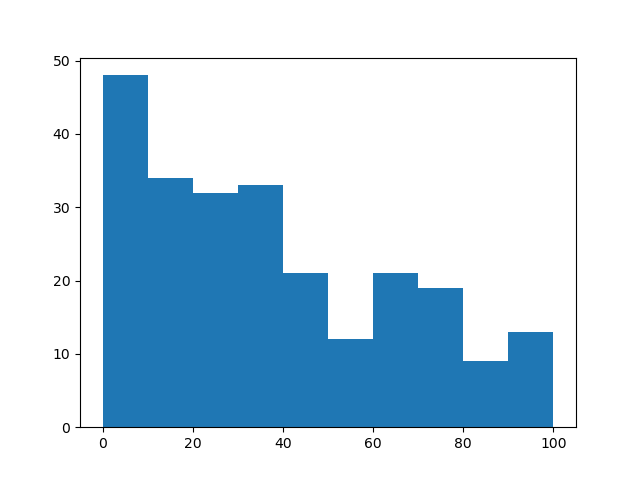

In [ ]:
plt.figure()
amount_of_corners = np.array([len(a) for a in out_dict.values()])
_ = plt.hist(amount_of_corners, range=(0, 100))
print(np.count_nonzero(amount_of_corners <= 10))

48


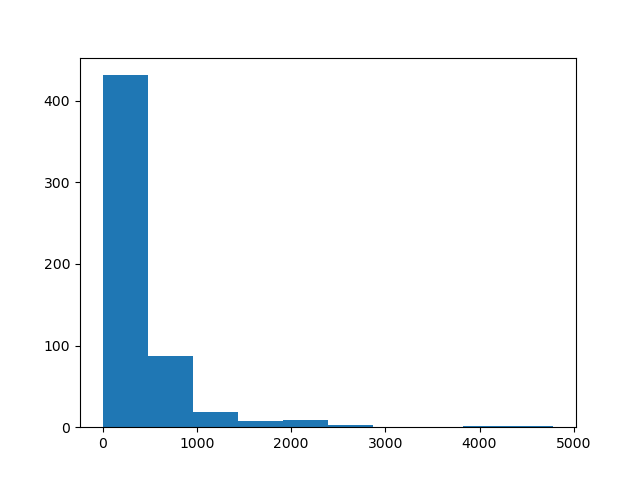